In [ ]:
import pandas as pd
import numpy as np
import json
import statsmodels.api as sm #for OLS
from sklearn.preprocessing import StandardScaler # for standardization
from linearmodels.panel import PanelOLS, RandomEffects # for FE/RE
import os

# 前處理
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:


    """針對單筆資料集做前處理"""

    yn_cols = ["facebook", "twitter", "instagram", "youtube", "twitch", "tiktok", "discord"] # 轉換yse/no 為 0/1
    for col in yn_cols:
        if col in df.columns:
            df[col] = (df[col].astype(str).str.lower() == "yes").astype(int)

    post_cols = [
        "text_posts", "image_posts", "video_posts", "audio_posts", "podcast_posts", "link_posts", "poll_posts", "livestream_posts"
    ]
    post_cols = [c for c in post_cols if c in df.columns]
    df[post_cols] = df[post_cols].fillna(0).astype(int)

    scaler = StandardScaler()
    z_vals = scaler.fit_transform(df[post_cols])
    df[[f"{c}_z" for c in post_cols]] = z_vals


    
    df["weekly_post_count"] = df[post_cols].sum(axis=1) # 計算每週發文總數

    df['eng_all'] = (df['public_likes']+df['locked_likes']+df['public_comments']+df['locked_comments']+1) # 計算所有互動總數(公開/私密都包含)

    df['eng_per_post'] = (np.log(df['eng_all'])+ 1) / (df['weekly_post_count'] + 1)

    df['weekly_post_count_w'] = df['weekly_post_count'].clip(upper=df['weekly_post_count'])
    df['log_post']            = np.log1p(df['weekly_post_count_w']) 
    df['log_post_z']          = StandardScaler().fit_transform(df[['log_post']])
    df['log_post_z_sq']       = df['log_post_z']**2

    #df["desc_length"] = df["description_word_count"].fillna("").str.len()

    # 對數轉換後的單篇互動數(將偏移的互動數拉回常態)
    df['log_eng_per_post'] = np.log1p(df['eng_per_post'].fillna(0))

    # 建 likes / comments 總量 + conversion_rate#
    df["total_likes"] = df["public_likes"] + df["locked_likes"]#
    df["total_comments"] = df["public_comments"] + df["locked_comments"]#

    df["conversion_rate"] = np.where(#
        df["about_total_members"] > 0,#
        df["about_paid_members"] / df["about_total_members"],#
        np.nan,# 
    )#
    
#
    def _tier_feats(raw): #拆解會籍JSON欄位 --> 會籍平均價格與平均會籍敘述字數
        try:
            tiers = json.loads(raw) if isinstance(raw, str) else []
        except json.JSONDecodeError:
            tiers = []
        if not tiers:
            return pd.Series([0.0, 0.0], index=["avg_tier_price", "avg_desc_wc"])
        prices = [tier.get("price", 0) for tier in tiers]
        wcs = [tier.get("description_word_count", 0) for tier in tiers]
        return pd.Series([np.mean(prices), np.mean(wcs)], index=["avg_tier_price", "avg_desc_wc"])

    if "membership_tiers_json" in df.columns:
        tier_df = df["membership_tiers_json"].apply(_tier_feats)
        df = pd.concat([df, tier_df], axis=1)

    return df


# 讀取csv檔案


def load_and_prepare():
    file_t1 = "patreon_data_w1.csv"
    file_t2 = "patreon_data_w2.csv"
    file_t3 = "patreon_data_w3.csv"
    file_t4 = "patreon_data_w4.csv"


    df_t1 = feature_engineering(pd.read_csv(file_t1))
    df_t2 = feature_engineering(pd.read_csv(file_t2))
    df_t3 = feature_engineering(pd.read_csv(file_t3))
    df_t4 = feature_engineering(pd.read_csv(file_t4))

    df_t1["week"] = 1
    df_t2["week"] = 2
    df_t3["week"] = 3
    df_t4["week"] = 4

    #  DataFrame for FE / RE
    df_panel = pd.concat([df_t1, df_t2, df_t3, df_t4], ignore_index=True)
    df_panel = df_panel.set_index(["creator_name", "week"]).sort_index()
    df_panel = df_panel.groupby(level=0).filter(lambda g: len(g) == 4)  # 改為4周完整數據

    return df_t1, df_t2, df_t3, df_t4, df_panel

    


# First‑Difference, Fixed‑Effects, Random‑Effects functions


def run_model(target="likes", mode="fd"):
    """mode: 'fd' | 'fe' | 're'"""

    df_t1, df_t2, df_t3, df_t4, df_panel = load_and_prepare()

    # First‑Difference(OLS)
    if mode == "fd":

        df_fd = (
            pd.concat([df_t1.assign(week=1),
                    df_t2.assign(week=2),
                    df_t3.assign(week=3), df_t4.assign(week=4)], ignore_index=True)
            .sort_values(["creator_name", "week"])
        )
        delta_cols = ["total_likes", "total_comments", "weekly_post_count",
              "social_link_count", "membership_tier_count",
              "income_per_month", "log_eng_per_post"]
        for v in delta_cols:
            df_fd[f"delta_{v}"] = df_fd.groupby("creator_name")[v].diff()

        # 只留下非 NaN 的差分 row (Week2–Week1, Week3–Week2)
        df_fd = df_fd.dropna(subset=[f"delta_{v}" for v in delta_cols])

        # 依 target 選 y / X

        if target == "likes":
            y_col  = "delta_total_likes"
            X_cols = ["delta_weekly_post_count","delta_social_link_count",
                    "delta_membership_tier_count",]

        elif target == "comments":
            y_col  = "delta_total_comments"
            X_cols = ["delta_weekly_post_count","delta_social_link_count",
                    "delta_membership_tier_count","delta_total_likes"
                    ]
            

        elif target == "eng_rate":
            y_col  = "Y_eng_rate_change"
            X_cols = ["delta_weekly_post_count","delta_social_link_count",
                    "delta_membership_tier_count",
                    "delta_total_likes","delta_total_comments"]
        else:
            raise ValueError("target 必須是 'likes' or 'comments' or 'eng_rate'")
        
        # 保證 y/x 同步資料筆(去除 NaN以及沒有兩筆資料都有的內容)

        tmp = df_fd[[y_col] + X_cols].dropna()
        y   = tmp[y_col]
        X   = sm.add_constant(tmp[X_cols])

        res = sm.OLS(y, X).fit()
        print(f"\n=== First-Difference OLS (Y = {y_col}) ===")
        print(res.summary())
        return res

    # Fixed‑Effects
    if mode == "fe":
        # 同fd，先選 y 與 X

        if target == "likes":
            y_col  = "total_likes"
            X_post_types = ["text_posts_z", "image_posts_z", "video_posts_z", "audio_posts_z", "link_posts_z", "poll_posts_z","podcast_posts_z", "livestream_posts_z"]
            X_cols = X_post_types + ["social_link_count",
                    "membership_tier_count",]
            
        elif target == "conversion_rate":
            y_col  = "conversion_rate"
            #X_post_types = ["text_posts_z", "image_posts_z", "video_posts_z", "audio_posts_z", "link_posts_z", "poll_posts_z", "podcast_posts_z", "livestream_posts_z"]
            X_cols = ["weekly_post_count" ,"social_link_count",
                    "membership_tier_count",]
            
        elif target == "eng_rate":
            X_post_types = ["text_posts_z", "image_posts_z", "video_posts_z", "audio_posts_z", "link_posts_z", "poll_posts_z", "podcast_posts_z", "livestream_posts_z"]
            y_col  = "eng_per_post"
            X_cols = X_post_types + ["social_link_count",
                    "membership_tier_count",
                    "total_likes","total_comments"]
            #"weekly_post_count""podcast_posts_z","livestream_posts_z"X_post_types + 
        else:
            raise ValueError("target 必須為 'likes'or'comments' or 'eng_rate'")

        # 同fd  
        tmp = df_panel[[y_col] + X_cols].dropna()

        tmp = tmp.groupby('creator_name').filter(lambda g: len(g)>=2)

        # 標準化 x 
        scaler = StandardScaler() #先做線性，之後先標準化再做二次項
        X_scaled_raw = pd.DataFrame(
            scaler.fit_transform(tmp[X_cols]),
            columns=X_cols, index=tmp.index
        )

        # 刪掉變異數為0的欄位
        const_cols = X_scaled_raw.columns[X_scaled_raw.std() == 0]
        X_scaled = X_scaled_raw.drop(columns=const_cols)

        X_const = sm.add_constant(X_scaled)

        # 定義 y(兩時間點，同創作者的總互動)

        y = tmp[y_col]



        fe_mod = PanelOLS(y, X_const, entity_effects=True, drop_absorbed=True)
        fe_res = fe_mod.fit(cov_type="clustered", cluster_entity=True)

        print(f"\n=== Fixed-Effects (Y = {target}) ===")
        print(fe_res.summary)
        return fe_res

    # Random‑Effects

    if mode == "re":

        # 同fd，先選 y 與 X
        if target == "likes":
            y_col  = "total_likes"
            #X_post_types = ["text_posts_z", "image_posts_z", "video_posts_z", "audio_posts_z", "link_posts_z", "poll_posts_z", "podcast_posts_z", "livestream_posts_z"]
            X_cols = ["weekly_post_count" ,"social_link_count",
                    "membership_tier_count"]
            
        elif target == "conversion_rate":
            y_col  = "conversion_rate"
            #X_post_types = ["text_posts_z", "image_posts_z", "video_posts_z", "audio_posts_z", "link_posts_z", "poll_posts_z", "podcast_posts_z", "livestream_posts_z"]
            X_cols = ["weekly_post_count" ,"social_link_count",
                    "membership_tier_count",]
            
        elif target == "eng_rate":
            y_col  = "eng_per_post"
            #X_post_types = ["text_posts_z", "image_posts_z", "video_posts_z", "audio_posts_z", "link_posts_z", "poll_posts_z", "podcast_posts_z", "livestream_posts_z"]
            X_cols = ["weekly_post_count" ,"social_link_count",
                    "membership_tier_count",
                    "total_likes","total_comments"]
            #X_post_types + 
        else:
            raise ValueError("target 必須是 'likes'、'comments' 或 'eng_rate'")

        tmp = df_panel[[y_col] + X_cols].dropna()


        tmp = tmp.groupby('creator_name').filter(lambda g: len(g)>=2)

        scaler = StandardScaler() #同FE，先做線性，之後先標準化再二次項
        X_scaled = pd.DataFrame(
            scaler.fit_transform(tmp[X_cols]),
            columns=X_cols, index=tmp.index
        )
        X_const = sm.add_constant(X_scaled)

        y = tmp[y_col]

        re_mod = RandomEffects(y, X_const)
        re_res = re_mod.fit(cov_type="clustered", cluster_entity=True)

        print(f"\n=== Random-Effects (Y = {target}) ===")
        print(re_res.summary)
        return re_res
    
        


# call

if __name__ == "__main__":
    # 範例 : run_model(target=" ", mode=" ")
    run_model(target="eng_rate", mode="re")





ValueError: No axis named 4 for object type DataFrame

In [ ]:
df_t1, df_t2, df_t3, df_t4, df_panel = load_and_prepare()

print("Index names  :", df_panel.index.names)
print("Is unique    :", df_panel.index.is_unique)
print(df_panel.head(3))

Index names  : ['creator_name', 'week']
Is unique    : True
                                                                                 URL  \
creator_name                            week                                           
#ResistanceLive: The Broadcast with ECM 1     https://www.patreon.com/ResistanceLive   
                                        2     https://www.patreon.com/ResistanceLive   
                                        3     https://www.patreon.com/ResistanceLive   

                                              total_post  patreon_number  \
creator_name                            week                               
#ResistanceLive: The Broadcast with ECM 1           3190          2974.0   
                                        2           3202          2995.0   
                                        3           3244          2919.0   

                                              income_per_month tier_post_data  \
creator_name                         

In [ ]:
run_model(target="conversion_rate", mode="fe")



=== Fixed-Effects (Y = conversion_rate) ===
                          PanelOLS Estimation Summary                           
Dep. Variable:        conversion_rate   R-squared:                        0.0328
Estimator:                   PanelOLS   R-squared (Between):              0.0050
No. Observations:                5649   R-squared (Within):               0.0328
Date:                Tue, Aug 05 2025   R-squared (Overall):              0.0051
Time:                        15:32:08   Log-likelihood                 1.609e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      47.805
Entities:                        1413   P-value                           0.0000
Avg Obs:                       3.9979   Distribution:                  F(3,4233)
Min Obs:                       2.0000                                           
Max Obs:                       4.0000   F-statistic (robust):   

Dep. Variable:,conversion_rate,R-squared:,0.0328
Estimator:,PanelOLS,R-squared (Between):,0.0050
No. Observations:,5649,R-squared (Within):,0.0328
Date:,"Tue, Aug 05 2025",R-squared (Overall):,0.0051
Time:,15:32:08,Log-likelihood,1.609e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,47.805
Entities:,1413,P-value,0.0000
Avg Obs:,3.9979,Distribution:,"F(3,4233)"
Min Obs:,2.0000,,
Max Obs:,4.0000,F-statistic (robust):,20.040


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 只抓 t2 (2025-06-09) 資料
# 經過對數轉換
_, df_t2, _ = load_and_prepare()         
df_t2['weekly_post_count_w'] = df_t2['weekly_post_count'].clip(upper=df_t2['weekly_post_count'])

sns.regplot(
    data=df_t2, x=np.log1p(df_t2['weekly_post_count_w']),
    y="log_eng_per_post", lowess=True, scatter_kws={'alpha':0.4}
)
plt.title("log(Weekly Posts) vs log Eng/Post")
plt.show()

ValueError: too many values to unpack (expected 3)

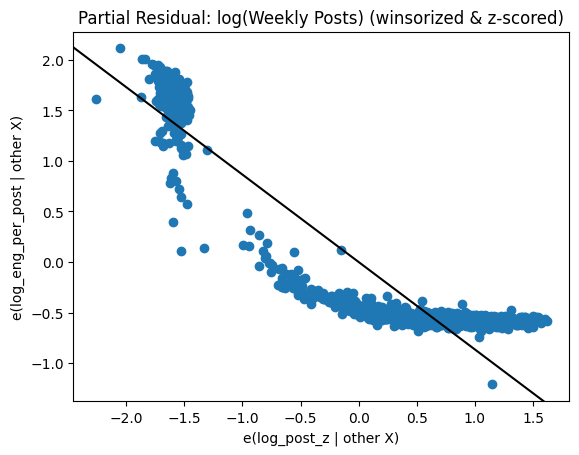

In [ ]:
from statsmodels.graphics.regressionplots import plot_partregress
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 取 t2 資料
cols = ["log_eng_per_post","weekly_post_count",
        "social_link_count","membership_tier_count",
        "income_per_month","total_likes","total_comments"]
tmp = df_t2[cols].dropna()

# 2. 先對 weekly_post_count 做 winsorize（PR99），再 做對數處理
post_w = tmp["weekly_post_count"].clip(upper=tmp["weekly_post_count"].quantile(0.99))
tmp["log_post"] = np.log1p(post_w)

tmp["log_post_z"] = StandardScaler().fit_transform(tmp[["log_post"]])

# 線性 OLS
y = tmp["log_eng_per_post"]
X = sm.add_constant(
        tmp.drop(columns=["log_eng_per_post","weekly_post_count","log_post"]) 
    )
base = sm.OLS(y, X).fit()

fig = plot_partregress(endog="log_eng_per_post",
                       exog_i="log_post_z",
                       exog_others=[c for c in X.columns if c not in ("const","log_post_z")],
                       data=tmp, obs_labels=False)
plt.title("Partial Residual: log(Weekly Posts) (winsorized & z-scored)")
plt.xlabel("e(log_post_z | other X)")
plt.ylabel("e(log_eng_per_post | other X)")
plt.show()

In [ ]:
df_t1, df_t2, df_long = load_and_prepare()   
df_fd = pd.merge(df_t1, df_t2, on="creator_name",
                 suffixes=("_t1","_t2"))   

import matplotlib.pyplot as plt
import statsmodels.api as sm
df_fd["delta_about_paid_members"]   = df_fd["about_paid_members_t2"] - df_fd["about_paid_members_t1"] #兩週會員數相減
df_fd["delta_weekly_post_count"]    = df_fd["weekly_post_count_t2"]  - df_fd["weekly_post_count_t1"] #兩週發文數相減



plt.scatter(df_fd["delta_weekly_post_count"],
            df_fd["delta_about_paid_members"], alpha=0.4)
# 加 LOWESS 平滑線
low = sm.nonparametric.lowess
curve = low(df_fd["delta_about_paid_members"],
            df_fd["delta_weekly_post_count"], frac=0.3)
plt.plot(curve[:,1], curve[:,0], color="k")
plt.xlabel("Δ weekly_post_count")
plt.ylabel("Δ paid_members")
plt.title("ΔPost vs ΔPaid Members (FD)")
plt.show()


ValueError: too many values to unpack (expected 3)

In [ ]:
df_t1, df_t2, df_long = load_and_prepare()   # 已做 feature_engineering
df_fd = pd.merge(df_t1, df_t2, on="creator_name",
                 suffixes=("_t1","_t2"))   

df_fd["delta_weekly_post_count"] = (
    df_fd["weekly_post_count_t2"] - df_fd["weekly_post_count_t1"]
)

df_fd["conv_rate_t1"] = df_fd["about_paid_members_t1"] / df_fd["about_total_members_t1"].replace(0,np.nan)
df_fd["conv_rate_t2"] = df_fd["about_paid_members_t2"] / df_fd["about_total_members_t2"].replace(0,np.nan)
df_fd["delta_conv_rate"] = df_fd["conv_rate_t2"] - df_fd["conv_rate_t1"]

plt.scatter(df_fd["delta_weekly_post_count"],
            df_fd["delta_conv_rate"], alpha=0.4)
curve = low(df_fd["delta_conv_rate"], df_fd["delta_weekly_post_count"], frac=0.3)
plt.plot(curve[:,1], curve[:,0], color="k")
plt.xlabel("Δ weekly_post_count")
plt.ylabel("Δ conversion_rate")
plt.title("ΔPost vs ΔConversion Rate (FD)")
plt.show()


ValueError: too many values to unpack (expected 3)

In [ ]:

df_t1, df_t2, df_t3, df_panel = load_and_prepare() 
import numpy as np, matplotlib.pyplot as plt, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 共用的 LOWESS 函式
low = sm.nonparametric.lowess
def plot_xy(x, y, xlab, ylab, title, frac=0.3):
    plt.figure()
    plt.scatter(x, y, alpha=0.4)
    curve = low(y, x, frac=frac)
    plt.plot(curve[:,0], curve[:,1], color="k")
    plt.xlabel(xlab); plt.ylabel(ylab); plt.title(title)
    plt.show()


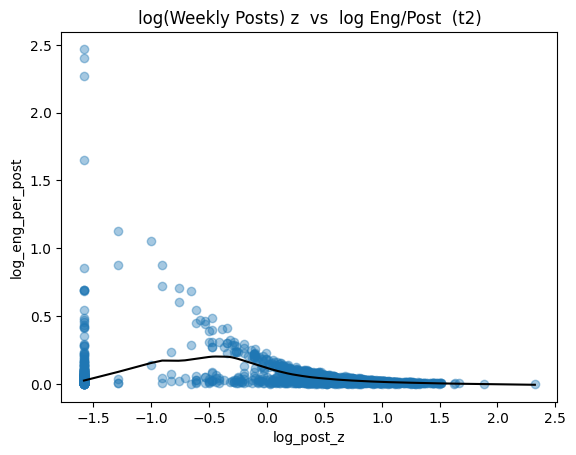

In [ ]:
# --- 對 t2 做 log + z-score ---
df_t3["weekly_post_count_w"] = df_t3["weekly_post_count"].clip(
    upper=df_t2["weekly_post_count"]
)
df_t3["log_post"] = np.log1p(df_t3["weekly_post_count_w"]) + 1 

sc = StandardScaler()
df_t3["log_post_z"] = sc.fit_transform(df_t3[["log_post"]])

plot_xy(df_t3["log_post_z"],
        df_t3["log_eng_per_post"],
        "log_post_z", "log_eng_per_post",
        "log(Weekly Posts) z  vs  log Eng/Post  (t3)")


